In [35]:
import numpy as np
import matplotlib.pyplot as plt
import os, jdc, shutil
from tqdm import tqdm
from rl_glue import RLGlue
from agent import BaseAgent
from maze_env import ShortcutMazeEnvironment

os.makedirs('results', exist_ok=True)

In [36]:
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'figure.figsize': [8,5]})

In [37]:
class DynaQAgent(BaseAgent):

    def agent_init(self, agent_info):
        try:
            self.num_states = agent_info["num_states"]
            self.num_actions = agent_info["num_actions"]
        except:
            print("You need to pass both 'num_states' and 'num_actions' \
                   in agent_info to initialize the action-value table")
        self.gamma = agent_info.get("discount", 0.95)
        self.step_size = agent_info.get("step_size", 0.1)
        self.epsilon = agent_info.get("epsilon", 0.1)
        self.planning_steps = agent_info.get("planning_steps", 10)

        self.rand_generator = np.random.RandomState(agent_info.get('random_seed', 42))
        self.planning_rand_generator = np.random.RandomState(agent_info.get('planning_random_seed', 42))
        self.q_values = np.zeros((self.num_states, self.num_actions))
        self.actions = list(range(self.num_actions))
        self.past_action = -1
        self.past_state = -1
        self.model = {} 

In [38]:
%%add_to DynaQAgent

# [GRADED]

def update_model(self, past_state, past_action, state, reward):
    if past_state not in self.model:
        self.model[past_state] = {}
    self.model[past_state][past_action] = (state, reward)


In [39]:
%%add_to DynaQAgent

# [GRADED]

def planning_step(self):

    for _ in range(self.planning_steps):
        past_state = self.planning_rand_generator.choice(list(self.model.keys()))
        past_action = self.planning_rand_generator.choice(list(self.model[past_state].keys()))
        state, reward = self.model[past_state][past_action]
        if state != -1:
            self.q_values[past_state][past_action] += self.step_size * (reward + self.gamma * np.max(self.q_values[state]) - self.q_values[past_state][past_action])
        else:
            self.q_values[past_state][past_action] += self.step_size * (reward - self.q_values[past_state][past_action])
    

### the planning Step

In [40]:
%%add_to DynaQAgent

# Do not modify this cell!

def argmax(self, q_values):
    """argmax with random tie-breaking
    Args:
        q_values (Numpy array): the array of action values
    Returns:
        action (int): an action with the highest value
    """
    top = float("-inf")
    ties = []

    for i in range(len(q_values)):
        if q_values[i] > top:
            top = q_values[i]
            ties = []

        if q_values[i] == top:
            ties.append(i)

    return self.rand_generator.choice(ties)

def choose_action_egreedy(self, state):
    if self.rand_generator.rand() < self.epsilon:
        action = self.rand_generator.choice(self.actions)
    else:
        values = self.q_values[state]
        action = self.argmax(values)

    return action

In [41]:
%%add_to DynaQAgent

def agent_start(self, state):

    action = self.choose_action_egreedy(state)
    self.past_state = state
    self.past_action = action

    
    return self.past_action

def agent_step(self, reward, state):

    self.q_values[self.past_state][self.past_action] += self.step_size * (reward + self.gamma * np.max(self.q_values[state]) - self.q_values[self.past_state][self.past_action])
    self.update_model(self.past_state, self.past_action, state, reward)
    self.planning_step()
    action = self.choose_action_egreedy(state)
    self.past_state = state
    self.past_action = action
    
    return self.past_action

def agent_end(self, reward):

    self.q_values[self.past_state][self.past_action] += self.step_size * (reward - self.q_values[self.past_state][self.past_action])
    self.update_model(self.past_state, self.past_action, -1, reward)
    self.planning_step()


### the agent start

### the agent step

In [44]:
def run_experiment(env, agent, env_parameters, agent_parameters, exp_parameters):

    # Experiment settings
    num_runs = exp_parameters['num_runs']
    num_episodes = exp_parameters['num_episodes']
    planning_steps_all = agent_parameters['planning_steps']

    env_info = env_parameters                     
    agent_info = {"num_states" : agent_parameters["num_states"],  # We pass the agent the information it needs. 
                  "num_actions" : agent_parameters["num_actions"],
                  "epsilon": agent_parameters["epsilon"], 
                  "discount": env_parameters["discount"],
                  "step_size" : agent_parameters["step_size"]}

    all_averages = np.zeros((len(planning_steps_all), num_runs, num_episodes)) # for collecting metrics 
    log_data = {'planning_steps_all' : planning_steps_all}                     # that shall be plotted later

    for idx, planning_steps in enumerate(planning_steps_all):

        print('Planning steps : ', planning_steps)
        os.system('sleep 0.5')                    # to prevent tqdm printing out-of-order before the above print()
        agent_info["planning_steps"] = planning_steps  

        for i in tqdm(range(num_runs)):

            agent_info['random_seed'] = i
            agent_info['planning_random_seed'] = i

            rl_glue = RLGlue(env, agent)          # Creates a new RLGlue experiment with the env and agent we chose above
            rl_glue.rl_init(agent_info, env_info) # We pass RLGlue what it needs to initialize the agent and environment

            for j in range(num_episodes):

                rl_glue.rl_start()                # We start an episode. Here we aren't using rl_glue.rl_episode()
                                                  # like the other assessments because we'll be requiring some 
                is_terminal = False               # data from within the episodes in some of the experiments here 
                num_steps = 0
                while not is_terminal:
                    reward, _, action, is_terminal = rl_glue.rl_step()  # The environment and agent take a step 
                    num_steps += 1                                      # and return the reward and action taken.

                all_averages[idx][i][j] = num_steps

    log_data['all_averages'] = all_averages
    np.save("results/Dyna-Q_planning_steps", log_data)
    

def plot_steps_per_episode(file_path):

    data = np.load(file_path, allow_pickle=True).item()
    all_averages = data['all_averages']
    planning_steps_all = data['planning_steps_all']

    for i, planning_steps in enumerate(planning_steps_all):
        plt.plot(np.mean(all_averages[i], axis=0), label='Planning steps = '+str(planning_steps))

    plt.legend(loc='upper right')
    plt.xlabel('Episodes')
    plt.ylabel('Steps\nper\nepisode', rotation=0, labelpad=40)
    plt.axhline(y=16, linestyle='--', color='red', alpha=0.4)
    plt.show()

Planning steps :  0


  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:04<00:00,  6.64it/s]


Planning steps :  5


100%|██████████| 30/30 [00:06<00:00,  4.34it/s]


Planning steps :  50


100%|██████████| 30/30 [00:46<00:00,  1.54s/it]


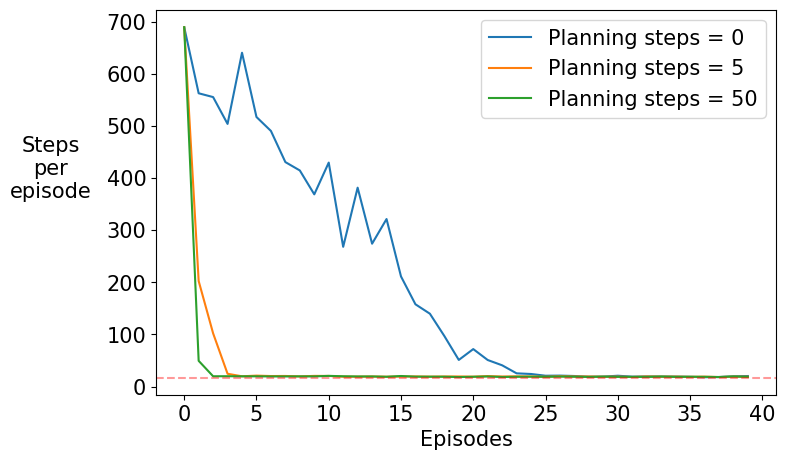

In [45]:
# Do NOT modify the parameter settings.

# Experiment parameters
experiment_parameters = {
    "num_runs" : 30,                     # The number of times we run the experiment
    "num_episodes" : 40,                 # The number of episodes per experiment
}

# Environment parameters
environment_parameters = { 
    "discount": 0.95,
}

# Agent parameters
agent_parameters = {  
    "num_states" : 54,
    "num_actions" : 4, 
    "epsilon": 0.1, 
    "step_size" : 0.125,
    "planning_steps" : [0, 5, 50]       # The list of planning_steps we want to try
}

current_env = ShortcutMazeEnvironment   # The environment
current_agent = DynaQAgent              # The agent

run_experiment(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters)
plot_steps_per_episode('results/Dyna-Q_planning_steps.npy')   
shutil.make_archive('results', 'zip', 'results');